In [1]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns
import random
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
import math
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve, auc, classification_report, roc_auc_score, average_precision_score, confusion_matrix, accuracy_score
!pip3 install eli5
!pip install shap
import eli5
from eli5.sklearn import PermutationImportance
import shap
from google.colab import drive 

Instructions for updating:
non-resource variables are not supported in the long term
     |████████████████████████████████| 106 kB 2.3 MB/s 
     |████████████████████████████████| 371 kB 2.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shap: filename=shap-0.40.0-cp37-cp37m-linux_x86_64.whl size=509233 sha256=1496da14a7e2534dc517cc32e08f69052fca146997ce966b42a79c127d7a594d
  Stored in directory: /root/.cache/pip/wheels/ec/35/84/e304841ac4b910bc95fe9a6e5302eb2507b4333728851dcbfb
Successfully built shap


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [32]:
# 데이터 로딩
df = pd.read_csv('/content/drive/Shareddrives/생체EMR 5팀/Data/time_series_knn_5.csv')
#del df["Unnamed: 0.1"]
df = df[['hadm_id', 'sbp', 'dbp', 'resp', 'hr', 'temp_c', 'spo2', 'crystalloid_bolus', 'rbc', 'urine', 'event']]
df

,hadm_id,sbp,dbp,resp,hr,temp_c,spo2,crystalloid_bolus,rbc,urine,event
0,199780,84.0,47.0,16.7,58.00,36.822240,83.200000,0.0,0.0,0.0,1.0
1,199780,90.0,52.0,16.0,58.00,36.777802,82.133333,0.0,0.0,0.0,1.0
2,199780,93.0,39.0,20.0,63.00,36.900020,86.500000,0.0,0.0,500.0,1.0
3,199780,103.0,40.0,20.0,56.00,36.333360,83.200000,0.0,0.0,0.0,1.0
4,199780,106.0,55.0,14.4,61.00,36.733360,88.800000,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
33067,100001,111.4,59.8,26.2,77.65,36.677750,89.200000,0.0,0.0,0.0,0.0
33068,100001,111.4,59.8,26.2,77.65,36.677750,89.200000,0.0,0.0,0.0,0.0
33069,100001,111.4,59.8,26.2,77.65,36.677750,89.200000,0.0,0.0,0.0,0.0
33070,100001,111.4,59.8,26.2,77.65,36.677750,89.200000,0.0,0.0,0.0,0.0


In [33]:
st = pd.read_csv('/content/drive/Shareddrives/생체EMR 5팀/Data/static_df.csv')
df = st.iloc[:,:3].merge(df)
df

,hadm_id,age,gender,sbp,dbp,resp,hr,temp_c,spo2,crystalloid_bolus,rbc,urine,event
0,100001,35,1,111.4,59.8,26.2,77.65,36.677750,89.200000,0.0,0.0,0.0,0.0
1,100001,35,1,111.4,59.8,26.2,77.65,36.677750,89.200000,0.0,0.0,0.0,0.0
2,100001,35,1,111.4,59.8,26.2,77.65,36.677750,89.200000,0.0,0.0,0.0,0.0
3,100001,35,1,111.4,59.8,26.2,77.65,36.677750,89.200000,0.0,0.0,0.0,0.0
4,100001,35,1,111.4,59.8,26.2,77.65,36.677750,89.200000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33067,199780,52,1,99.0,61.0,20.0,77.00,36.733320,89.133333,0.0,0.0,250.0,0.0
33068,199780,52,1,100.0,56.0,20.0,75.00,36.666680,82.260000,0.0,0.0,0.0,0.0
33069,199780,52,1,113.0,77.0,20.0,88.00,36.494430,80.300000,0.0,0.0,0.0,0.0
33070,199780,52,1,103.0,55.0,16.0,73.00,37.222198,79.860000,0.0,0.0,0.0,0.0


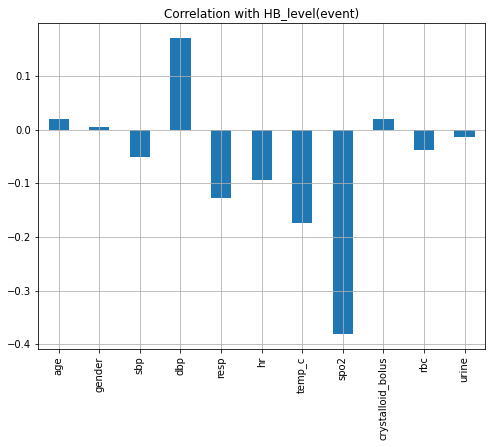

In [35]:
# event와 다른 feature 간의 correlation 

df.drop(['hadm_id', 'event'], axis=1).corrwith(df.event).plot(kind='bar', grid=True, figsize=(8, 6), title="Correlation with HB_level(event)")

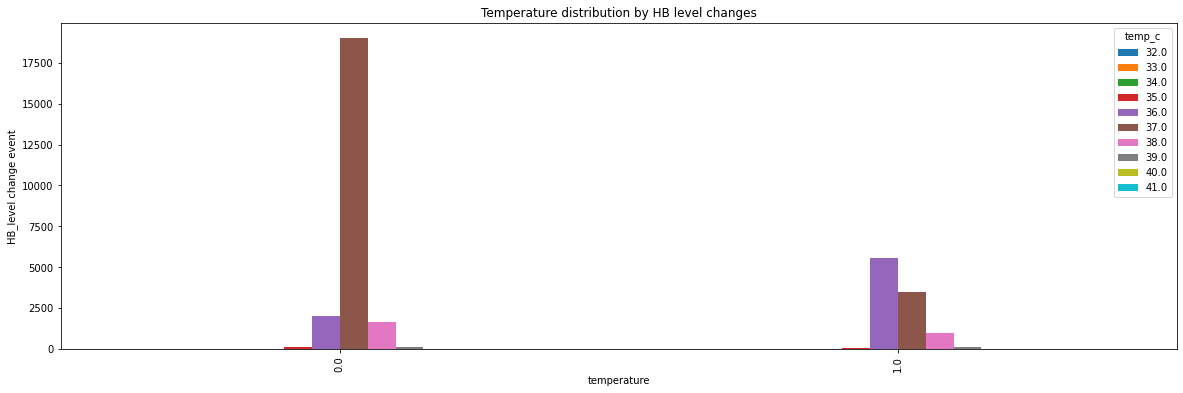

In [36]:
pd.crosstab(df.event,df.temp_c.round()).plot(kind="bar",figsize=(20,6))
plt.title('Temperature distribution by HB level changes')
plt.xlabel('temperature')
plt.ylabel('HB_level change event')
plt.show()

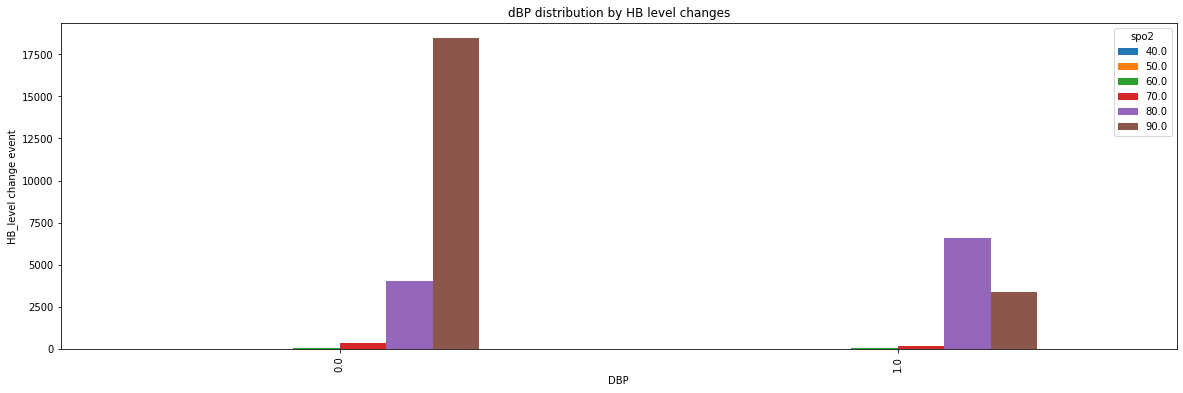

In [37]:
pd.crosstab(df.event,df.spo2.round(-1)).plot(kind="bar",figsize=(20,6))
plt.title('dBP distribution by HB level changes')
plt.xlabel('DBP')
plt.ylabel('HB_level change event')
plt.show()

In [38]:
# hadm_id 중복없이 리스트로 뽑고, df의 hadm_id에 해당하는 column의 데이터(프레임)를 x에 numpy array로 저장 
# hadm_id가 중복되면 (case 2개 이상), 한 hadm_id에 numpy array가 24 단위로 증가된 것만 남고, 나머지는 제거됨   

hadm_id =list(set(df['hadm_id'].tolist()))
column_name = ['age', 'gender', 'sbp', 'dbp', 'resp', 'hr', 'temp_c', 'spo2', 'crystalloid_bolus', 'rbc', 'urine', 'event']
x = [df[df['hadm_id']==i][column_name].to_numpy() for i in hadm_id]


In [39]:
# 입력 데이터 만들기 
# x를 받아서 array가 48인 것은 event값에 따라 나누고, 24인 것과 최종 final_x, final_y로 지정

def data_split(np_array_list):
  final_x, final_y = [], []
  for np_array in np_array_list:
    if len(np_array) == 48:
      final_x.append(np_array[np.where(np_array[:, -1]==0)][:, :-1])
      final_y.append(0)
      final_x.append(np_array[np.where(np_array[:, -1]==1)][:, :-1])
      final_y.append(1)
    else:
      label = np_array[0, -1]
      final_x.append(np_array[:, :-1])
      final_y.append(label)

  return np.array(final_x), np.array(final_y)

In [40]:
final_x, final_y = data_split(x)
print("x shape:", final_x.shape, "y shape:", final_y.shape)

x shape: (1378, 24, 11) y shape: (1378,)


In [41]:
# train/test set 나누기 (7:3)  (colab에서 fit -> validation_data에 오류있어 사용 어려움)

x_train, x_test, y_train, y_test = train_test_split(final_x, final_y, random_state=100, test_size=0.3, shuffle=True) 
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(964, 24, 11)
(414, 24, 11)
(964,)
(414,)


In [42]:
# 모델 구성 (LSTM)

ls_model = Sequential()
ls_model.add(LSTM(64, input_shape=(final_x.shape[1],11))),
ls_model.add(Dense(125, activation='relu')),
ls_model.add(Dense(1, activation='sigmoid'))

ls_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                19456     
                                                                 
 dense_4 (Dense)             (None, 125)               8125      
                                                                 
 dense_5 (Dense)             (None, 1)                 126       
                                                                 
Total params: 27,707
Trainable params: 27,707
Non-trainable params: 0
_________________________________________________________________


In [43]:
# 데이터 불균형 정도
neg, pos = np.bincount(df['event'])
total = neg + pos
print('Total: {}\n  Positive: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Total: 33072
  Positive: 10200 (30.84% of total)

Weight for class 0: 0.72
Weight for class 1: 1.62


In [44]:
# 학습
from keras.callbacks import EarlyStopping

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
early_stopping = EarlyStopping(monitor='loss', patience=30, mode='min')
ls_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
num_epochs = 200
history = ls_model.fit(x_train, y_train, epochs=num_epochs, class_weight = class_weight, batch_size = 15, validation_split=0.2, callbacks = [early_stopping], verbose=1)

Train on 771 samples, validate on 193 samples
Epoch 1/200
771/771 [==============================] - 1s 1ms/sample - loss: 0.6551 - acc: 0.6174 - val_loss: 0.6095 - val_acc: 0.7047
Epoch 2/200
 15/771 [..............................] - ETA: 0s - loss: 0.4634 - acc: 1.0000

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


771/771 [==============================] - 1s 889us/sample - loss: 0.5762 - acc: 0.7315 - val_loss: 0.5598 - val_acc: 0.6943
Epoch 3/200
771/771 [==============================] - 1s 895us/sample - loss: 0.5239 - acc: 0.7237 - val_loss: 0.5223 - val_acc: 0.7617
Epoch 4/200
771/771 [==============================] - 1s 908us/sample - loss: 0.4806 - acc: 0.7665 - val_loss: 0.5046 - val_acc: 0.7979
Epoch 5/200
771/771 [==============================] - 1s 880us/sample - loss: 0.4438 - acc: 0.8016 - val_loss: 0.4676 - val_acc: 0.7720
Epoch 6/200
771/771 [==============================] - 1s 888us/sample - loss: 0.4361 - acc: 0.7821 - val_loss: 0.5484 - val_acc: 0.7772
Epoch 7/200
771/771 [==============================] - 1s 884us/sample - loss: 0.4277 - acc: 0.8106 - val_loss: 0.4460 - val_acc: 0.8187
Epoch 8/200
771/771 [==============================] - 1s 904us/sample - loss: 0.3991 - acc: 0.8132 - val_loss: 0.4409 - val_acc: 0.8342
Epoch 9/200
771/771 [==============================] 

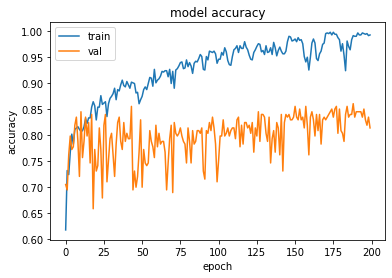

In [45]:
# Model Accuracy

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

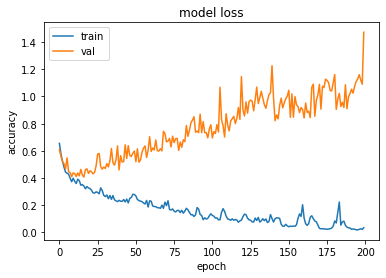

In [46]:
# Model Loss 

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [47]:
# 모델 평가

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='blue', label='ROC')
    plt.plot([0, 1], [0, 1], color='skyblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()
    

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


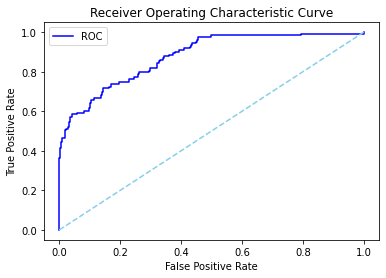

In [48]:
y_pred = (ls_model.predict(x_test) > 0.5).astype("int32")
y_prob = ls_model.predict_on_batch(x_test)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plot_roc_curve(fpr, tpr)

In [49]:
#loss, accuracy = ls_model.evaluate(x_test, y_test, batch_size=1) 
#print('Loss: %.4f' % loss, 'Accuracy: % .4f' % accuracy )
print("{} Accuracy Score: {:.2f}%".format(2, accuracy_score(y_test, y_pred)*100))
print('AUC: %.4f' % roc_auc_score(y_test, ls_model.predict(x_test)))
print(classification_report(y_test, y_pred))

2 Accuracy Score: 81.40%
AUC: 0.8782
              precision    recall  f1-score   support

         0.0       0.84      0.90      0.87       291
         1.0       0.73      0.60      0.66       123

    accuracy                           0.81       414
   macro avg       0.78      0.75      0.77       414
weighted avg       0.81      0.81      0.81       414



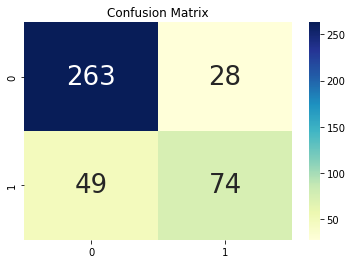

In [50]:
cm = confusion_matrix(y_test,y_pred)
cm_norm = confusion_matrix(y_test, y_pred, normalize='all')
plt.title("Confusion Matrix")
sns.heatmap(cm, annot=True, cmap="YlGnBu", fmt="d", cbar=True, annot_kws={"size": 26})

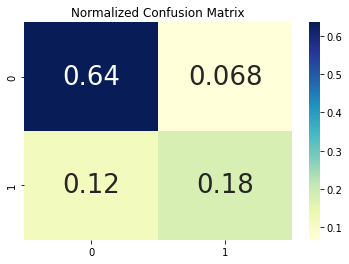

In [51]:
plt.title("Normalized Confusion Matrix")
sns.heatmap(cm_norm, annot=True, cmap="YlGnBu", cbar=True, annot_kws={"size": 26})

In [54]:
features = df.columns[-12:-1]
background = x_train[np.random.choice(x_train.shape[0], 110, replace=False)]
explainer = shap.DeepExplainer((ls_model.layers[0].input, ls_model.layers[-1].output), background)
shap_values = explainer.shap_values(x_train[:10000]) 

# print the JS visualization code to the notebook
shap.initjs()
#shap.force_plot(explainer.expected_value[0], shap_values[0][0], feature_names=features)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


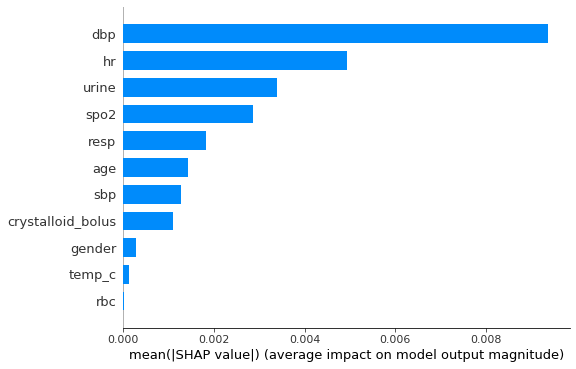

In [55]:
shap.summary_plot(shap_values[0][:, 0, :], x_train[:][:, 0, :], features, plot_type="bar")

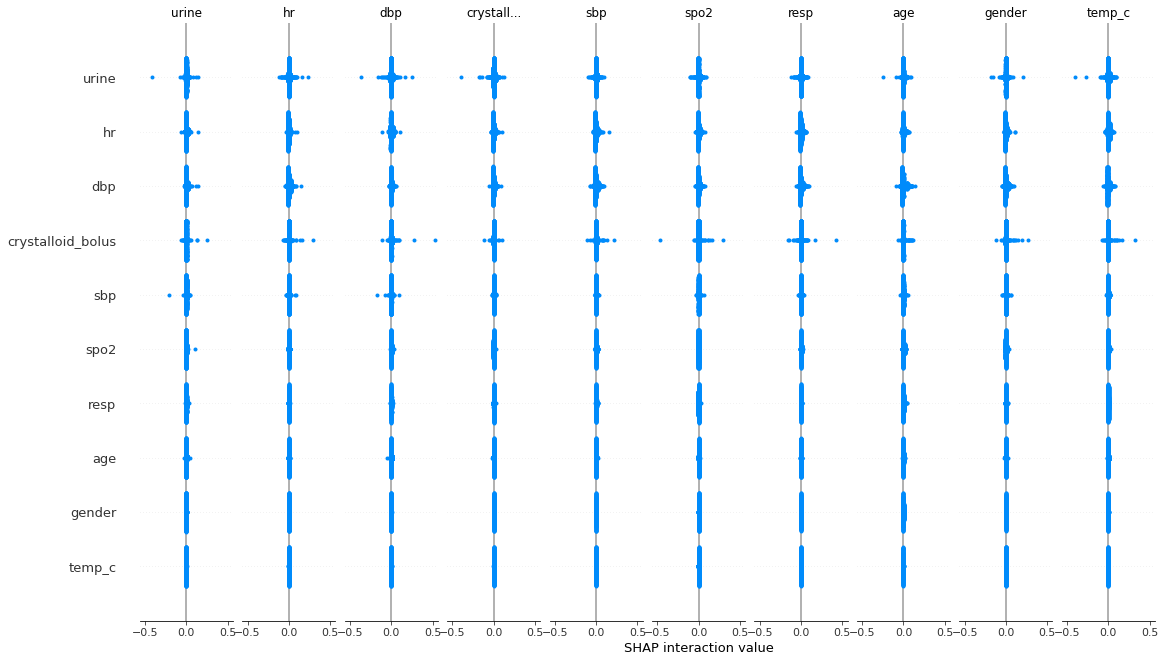

In [56]:
shap.summary_plot(shap_values[0],feature_names=features, max_display=10, plot_type='bar')